In [ ]:
# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor

In [ ]:
# Değişkenler
# InvoiceNo : Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem
# StockCode : Üürn kodu. Her bir gün için eşsiz numara.
# Description : Ürün ismi.
# Quantity : Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate : Fatura tarihi ve zamanı.
# UnitPrice : Ürün fiyatı (Sterlin cinsinden)
# CustomerID : Eşsiz müşteri numarası
# Country : Ülke ismi. Müşterinin yaşadığı ülke.

In [3]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np
import warnings

pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 1000)
warnings.filterwarnings("ignore")

df_ = pd.read_excel("/content/online_retail_II-230817-120704.xlsx", sheet_name="Year 2009-2010")


In [5]:
df = df_.copy()

In [6]:
# Genel olarak bir veri setimize bakalım
def check_df(dataframe, head=5):
  print("##################### Shape ##################### ")
  print(dataframe.shape)
  print("##################### Types ##################### ")
  print(dataframe.dtypes)
  print("##################### Head ##################### ")
  print(dataframe.head(head))
  print("##################### Tail ##################### ")
  print(dataframe.tail(head))
  print("##################### NA ##################### ")
  print(dataframe.isnull().sum())
  print("###################### Quanties ###################### ")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [7]:
def select_country(dataframe, country):
  new_dataframe = dataframe[dataframe["Country"] == country]
  return new_dataframe

In [8]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [9]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

In [10]:
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit) , variable] = low_limit   # Alt aykırı değer varsa low_limit ' e eşitle
  dataframe.loc[(dataframe[variable] > up_limit) , variable] = up_limit     # Üst aykırı

In [11]:
check_df(df)

##################### Shape ##################### 
(525461, 8)
##################### Types ##################### 
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head ##################### 
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2

In [12]:
# Mesela üstte describe kısmında quantity eksi neden çünkü ürün iade edilmiş mesela.
# Aynı şekilde negatif price olanlarda iade anlamına geliyor
# Sondaki Quanties kısmında ise bazı değerlerimizde %99 ile %100 arasında büyük bir fark var. Aykırı değer olabilir.

In [13]:
df["Invoice"] = df["Invoice"].astype(str)

In [14]:
# Şimdi veri ön işleme kısmına geçelim
df = df[~df["Invoice"].str.contains("C", na=False)]  # İade olmayanları seçiyor burada
df = df[(df["Quantity"] > 0)]    # Adet sayısı sıfırdan büyük olanları seçiyoruz
df.dropna(inplace=True)   # Eksik değerleride silmek lazım. Çünkü eksik değer olunca k_means gibi algoritmalar çalışamıyor

In [15]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,InvoiceDate,Price,Customer ID
count,407695.00,407695,407695.00,407695.00
mean,13.59,2010-07-01 10:10:10.782177792,3.29,15368.50
min,1.00,2009-12-01 07:45:00,0.00,12346.00
1%,1.00,2009-12-02 15:10:00,0.29,12435.00
10%,1.00,2010-01-19 11:01:00,0.65,13044.00
25%,2.00,2010-03-26 14:01:00,1.25,13997.00
50%,5.00,2010-07-09 15:46:00,1.95,15321.00
75%,12.00,2010-10-14 17:09:00,3.75,16812.00
90%,24.00,2010-11-18 10:37:00,6.75,17706.00
99%,144.00,2010-12-07 14:31:00,14.95,18196.00


In [16]:
# Negatf Quantity'lerden kurtulduk. Price sıfır olabilir belki hediye olarak yolladık.

In [17]:
df[df["Price"] == 0]["StockCode"].unique()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [18]:
df = df[df["StockCode"] != "M"]  # m olanları çıkartıyoruz üstte dediğimiz gibi hediye ile ilgili olanlar olabilir
# Veya stok dışı veya yanlış işlem olabilir.

In [19]:
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()  # Bu biraz iş bilgisi geçerli olmayan kodları attık
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [20]:
df[df["StockCode"].isin(invalid_codes)].groupby(["StockCode"]).agg({"Invoice": "nunique",
                                                                    "Quantity": "sum",
                                                                    "Price": "sum",
                                                                    "Customer ID": "nunique"})
# Bu işlemler, geçersiz ürün kodlarının satış ve müşteri etkileşimi hakkında bilgi edinmek için yapılır.

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


In [21]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index (drop=True)

In [22]:
check_df(df)

##################### Shape ##################### 
(406450, 8)
##################### Types ##################### 
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head ##################### 
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2

In [23]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [24]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00


In [25]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,406450.00,406450,406450.00,406450.00,406450.00
mean,13.62,2010-07-01 10:28:27.142084608,3.01,15373.48,21.36
min,1.00,2009-12-01 07:45:00,0.00,12346.00,0.00
1%,1.00,2009-12-02 15:04:00,0.29,12437.00,0.65
10%,1.00,2010-01-19 10:41:00,0.65,13050.00,2.10
25%,2.00,2010-03-26 14:01:00,1.25,14006.00,4.95
50%,5.00,2010-07-09 15:48:00,1.95,15325.00,11.85
75%,12.00,2010-10-14 17:09:00,3.75,16814.00,19.50
90%,24.00,2010-11-18 10:37:00,6.75,17706.00,35.40
99%,144.00,2010-12-07 14:31:00,12.75,18196.00,197.10


In [26]:
# Üstte max'daki TotalPrice ayrkırı değer gibi gözüküyor

In [27]:
max_invoice_date = df["InvoiceDate"].max()
today_date = (max_invoice_date + dt.timedelta(days=2))   # İşlmeleri 2 gün sonraya göre oluşturacağım

In [28]:
print(today_date)

2010-12-11 20:01:00


In [32]:
print(max_invoice_date)

2010-12-09 20:01:00


In [33]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,   # Recency Metriği
                                      "Invoice": "nunique",    # Frequency Metriği
                                      "TotalPrice": "sum"})    # Monetary Metriği

In [35]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [36]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0 & (rfm["Frequency"] > 0)]

In [37]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [38]:
rfm.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.43,2025.18
std,96.35,7.95,8829.91
min,2.00,1.00,1.55
1%,2.00,1.00,40.76
10%,9.00,1.00,157.03
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
90%,255.00,9.00,3761.56


In [39]:
for col in rfm.columns:
  print(col, check_outlier(rfm, col))

Recency False
Frequency True
Monetary True


In [40]:
for col in rfm.columns:
  replace_with_thresholds(rfm, col)

In [41]:
rfm.describe()

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.11,1588.58
std,96.35,4.89,2523.16
min,2.00,1.00,1.55
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
max,375.00,31.00,15243.20


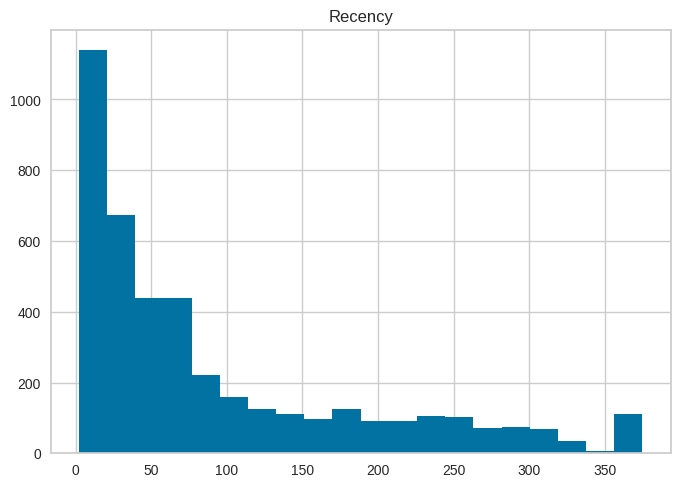

In [42]:
rfm["Recency"].hist (bins=20)
plt.title("Recency")
plt.show()

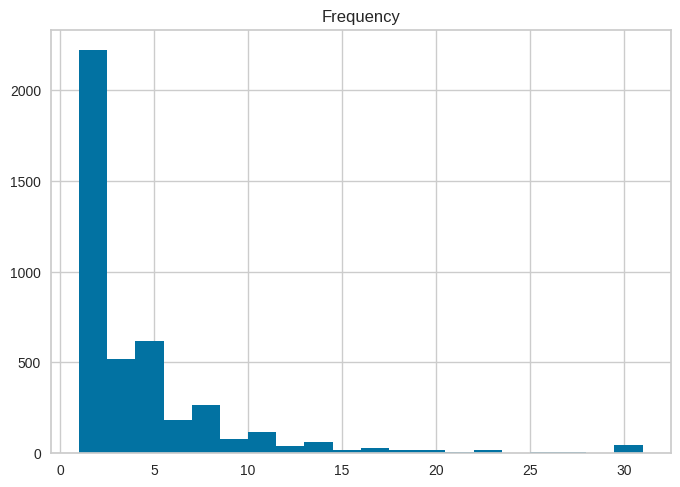

In [43]:
rfm["Frequency"].hist (bins=20)
plt.title("Frequency")
plt.show()

In [44]:
# Üstteki grafiklerden verilerimizin sola çarpık olduğunu görebiliyoruz. Bu nedenle, bu çarpıklığı azaltmak için logaritmik dönüşüm uygulayacağız.
# Bu dönüşüm, verilerin daha normal bir dağılıma sahip olmasına yardımcı olacak.

In [45]:
# LOG TRANSFORMATION
for col in ["Recency", "Frequency"]:
  rfm[f"LOG_{col}"] = np.log1p(rfm[col])
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166.00,2,169.36,5.12,1.10
12347.00,4.00,2,1323.32,1.61,1.10
12348.00,75.00,1,221.16,4.33,0.69
12349.00,44.00,2,2221.14,3.81,1.10
12351.00,12.00,1,300.93,2.56,0.69


In [46]:
# SCALER
sc = StandardScaler()
sc.fit(rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform(rfm[["LOG_Recency", "LOG_Frequency"]])

In [47]:
scaled_df = pd.DataFrame(index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
print(scaled_df)

             LOG_Recency  LOG_Frequency
Customer ID                            
12346.00            0.99          -0.40
12347.00           -1.85          -0.40
12348.00            0.35          -1.00
12349.00           -0.07          -0.40
12351.00           -1.08          -1.00
...                  ...            ...
18283.00           -0.73           0.87
18284.00            0.27          -1.00
18285.00            1.45          -1.00
18286.00            0.68          -0.40
18287.00           -0.73           0.37

[4286 rows x 2 columns]


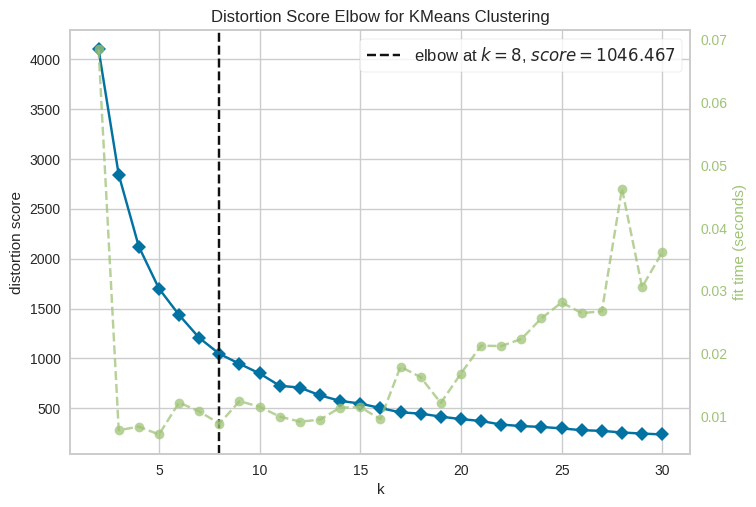

In [48]:
# Determining Optimal Numbers of Cluster
kmeans = KMeans()
elbow = KElbowVisualizer (kmeans, k=30)
elbow.fit (scaled_df)
elbow.show ();

In [49]:
k_ = elbow.elbow_value_
print(k_)

8


In [50]:
# K- Means
k_means = KMeans(n_clusters=k_, random_state=99).fit(scaled_df)
segments = k_means.labels_

In [51]:
segments

array([6, 5, 0, ..., 3, 6, 4], dtype=int32)

In [52]:
rfm["KMeans_Segment"] = segments
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segment
Customer ID,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,6
12347.00,4.00,2,1323.32,1.61,1.10,5
12348.00,75.00,1,221.16,4.33,0.69,0
12349.00,44.00,2,2221.14,3.81,1.10,0
12351.00,12.00,1,300.93,2.56,0.69,5


In [53]:
rfm.groupby("KMeans_Segment").agg({"Recency": ["mean","median","count"],
                                   "Frequency":["mean","median","count"],
                                   "Monetary": ["mean","median","count"]})

Recency              Frequency              Monetary              
                  mean median count      mean median count     mean  median count
KMeans_Segment                                                                   
0                57.64  57.00   798      1.36   1.00   798   528.08  352.85   798
1                14.45   9.00   285     18.60  16.00   285  7891.10 6615.77   285
2                65.86  60.00   654      4.64   4.00   654  1863.97 1366.70   654
3               243.85 241.00   743      1.00   1.00   743   316.59  226.90   743
4                21.30  18.50   536      6.59   6.00   536  2448.02 1978.51   536
5                15.96  17.00   514      1.95   2.00   514   627.66  488.92   514
6               184.04 173.00   530      2.65   2.00   530   961.10  649.31   530
7                 3.96   4.00   226      6.70   6.50   226  2388.86 1898.85   226

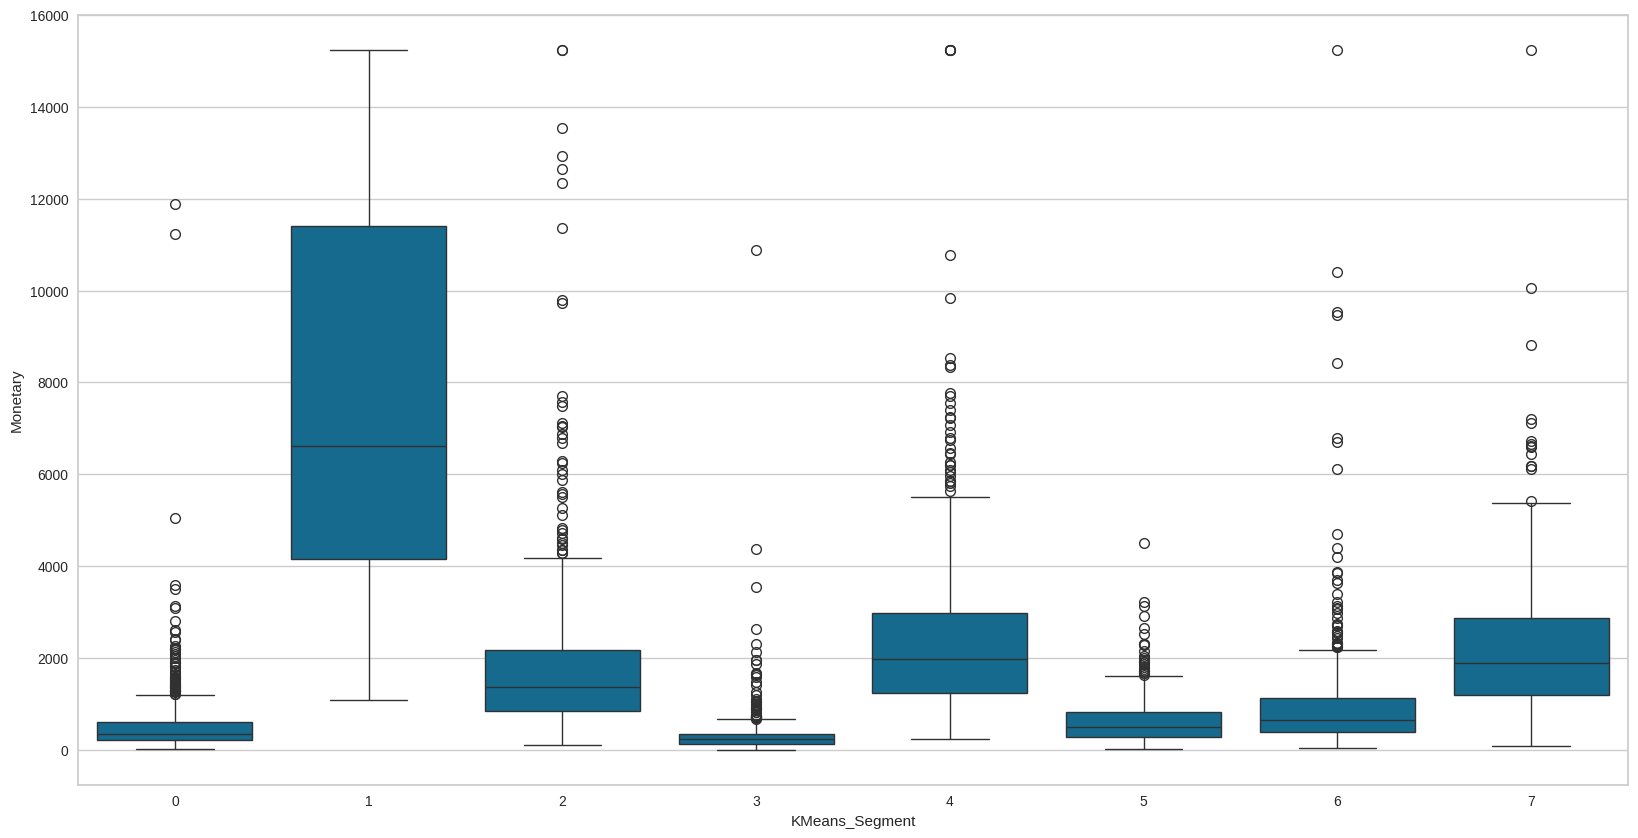

In [54]:
plt.figure(figsize=(20,10))
sns.boxplot(x="KMeans_Segment", y="Monetary", data=rfm)
plt.show();

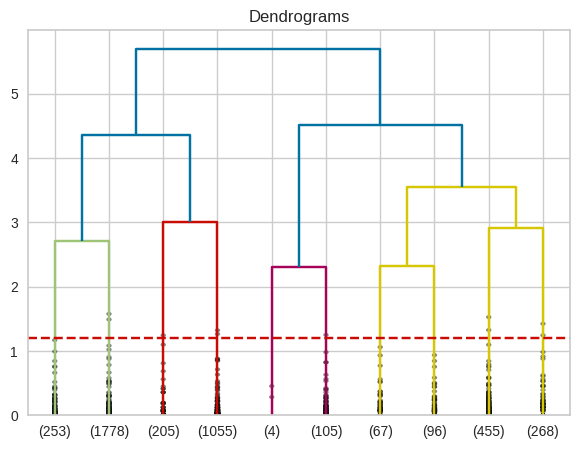

In [55]:
# Hierarchical Clustering

hc_complete = linkage(scaled_df, "complete")
plt.figure(figsize=(7,5))
plt.title("Dendrograms")
dend = dendrogram (hc_complete,
                   truncate_mode="lastp",
                   p=10,
                   show_contracted=True,
                   leaf_font_size=10)

plt.axhline(y=1.2, color="r", linestyle="--")
plt.show();

In [56]:
hc = AgglomerativeClustering(n_clusters=6)
segments = hc.fit_predict(scaled_df)
rfm["Hierarchi_Segment"] = segments

In [57]:
rfm.groupby("Hierarchi_Segment").agg({"Recency": ["mean","median","count"],
                                   "Frequency":["mean","median","count"],
                                   "Monetary": ["mean","median","count"]})

Recency              Frequency              Monetary              
                     mean median count      mean median count     mean  median count
Hierarchi_Segment                                                                   
0                   22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                   71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                  227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                   13.24  13.00   462      2.05   2.00   462   654.60  498.73   462
4                   55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                    5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

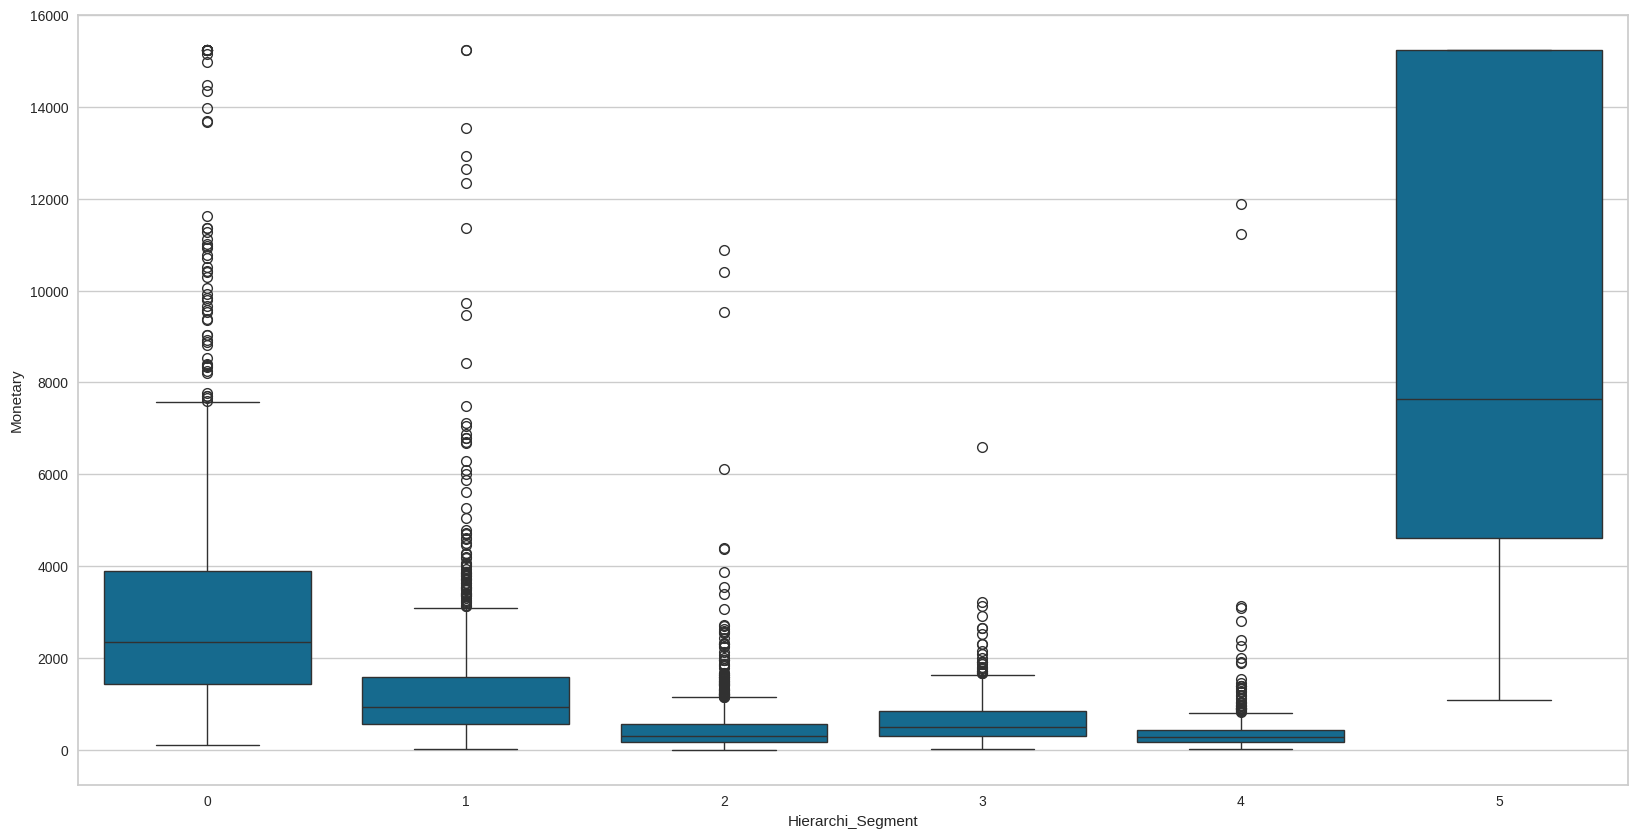

In [58]:
plt.figure(figsize=(20,10))
sns.boxplot(x="Hierarchi_Segment", y="Monetary", data=rfm)
plt.show();